In [1]:

#by Henry Schumacher
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import time
start_setup = time.process_time_ns()
print('---------------------------------------')
print(time.strftime("PIXE_results.ipynb started: %a, %d %b %Y %H:%M:%S", time.localtime()))
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import os
import sys
import json
import uuid
import h5py
import math
import xraydb
import plotly
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import numpy as np
import pandas as pd
# import pyxray as xy
import odrpack as odr
import seaborn as sb
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from getmac import get_mac_address as gma
from itertools import chain
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea, VPacker
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from colors import load_colors
from PIXE_functions import *
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.usetex": True,
    "font.size": 8,
    "pgf.rcfonts": False
})


plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
          r'\usepackage{amsmath}',
     ]),
})

#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
color_schemes = load_colors()


end_setup = time.process_time_ns()
elapsed_setup = (end_setup - start_setup)/1e6

print(f'INFO: SETUP COMPLETE ({elapsed_setup:.2f} ms)')
print('---------------------------------------')
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#

---------------------------------------
PIXE_results.ipynb started: Sun, 01 Mar 2026 19:45:23
INFO: SETUP COMPLETE (1796.88 ms)
---------------------------------------


In [2]:
def read_json_formatted_file(filepath, encoding="utf-8"):
    """
    Reads a file whose contents are JSON-formatted, regardless of file extension.

    Parameters:
        filepath (str): Path to the file
        encoding (str): File encoding (default: utf-8)

    Returns:
        dict or list: Parsed JSON content

    Raises:
        ValueError: If the file content is not valid JSON
        OSError: If the file cannot be read
    """
    with open(filepath, "r", encoding=encoding) as f:
        content = f.read()

    try:
        return json.loads(content)
    except json.JSONDecodeError as e:
        raise ValueError(f"File content is not valid JSON: {e}") from e
    
def file_collector(measurement:str):
    file_collection = []
    top_level_path = f'.//{measurement}'
    for file in os.listdir(top_level_path):
        if (file[-5:] == '.vspc'):
            full_path = top_level_path + '//' + file
            file_collection.append(full_path)
    return file_collection

def pixe_single_spectrum_plot(filename:str):
    '''
    This function will produce a simple labeled plot of uncalibrated raw-data.
    '''
    DPI = 250
    data = read_json_formatted_file(filename)
    meas_name = filename.split('//')[2].split('.')[0]
    meas_folder = filename.split('//')[1]
    
    energyPerBin = data['Calibration']['BinSize_keV/Bin'] # keV/bin
    bin_data = data['RawData'][:-1] #remove that overflow bin at position 8191
    total_counts = np.sum(bin_data)
    total_counts_incl = np.sum(data['RawData'])
    # print(bin_data)
    
    bins = np.arange(0,len(bin_data),1)
    
    scatter_color = color_schemes['c_dark']
    
    fig, ax = plt.subplots(figsize=(6,3), dpi=DPI)
    # ax.set_facecolor(color_schemes['c_back'])
    # ax.plot(bins, bin_data, lw=0.75, color=scatter_color[0], zorder=2)
    ax.step(bins, bin_data, lw=0.75, color=scatter_color[3], zorder=2)
    
    if (len(bin_data) == 8191):
        ax.set_xlim(0,8193)
        ax.set_xticks(np.arange(0,8193,1024),np.arange(0,8193,1024))
    elif (len(bin_data) == 4095):
        ax.set_xlim(0,4095)
        ax.set_xticks(np.arange(0,4097,512),np.arange(0,4097,512))
    elif (len(bin_data) == 2047):
        ax.set_xlim(0,2047)
        ax.set_xticks(np.arange(0,2049,512),np.arange(0,2049,512))
        
        
    plt.xlabel('MCA channel')
    plt.ylabel('Counts')
    
    plt.grid(which="both")
    plt.tight_layout()

    #----------------- Information Box -----------------#
    #det_pic_file = detector_pic(measurement['det_id'])
    # img = plt.imread(det_pic_file)
    annotation = TextArea(f"X-ray measurement \n {meas_name} \n UNCALIBRATED \n Total Counts: {total_counts}", textprops=dict(color="black", fontsize=5, multialignment='center'))
    # imagebox = OffsetImage(img, zoom=0.05)
    stacked = VPacker(children=[annotation],
                 align="center",
                 pad=0,
                 sep=5)
    
    ab = AnnotationBbox(offsetbox=stacked, xy=(0.9,0.85), xycoords='axes fraction', frameon=True)

    ax.add_artist(ab)
    #----------------- Information Box -----------------#

    
    plt.savefig(f'./plots/uncalibrated/{meas_folder}/{meas_name}.png', dpi=DPI)
    plt.savefig(f'./plots/uncalibrated/{meas_folder}/{meas_name}.pdf', dpi=DPI)
    
    plt.show()

def all_files_from_measSet(m_name:str):
    f_c = file_collector(m_name)
    for file in f_c:
        pixe_single_spectrum_plot(file)
    return 4

In [3]:
# pixe_single_spectrum_plot('.//2026_02_26//20260226-155629.vspc')

In [4]:
# f_n = all_files_from_measSet('2026_02_27')
# print(f_n)


## To-Do:

#### Energy Calibration with Amersham Source Data

#### Upload to Confluence: Docu for Detector

In [5]:
def peak_fitter(file:str, init_values:list):
    data = read_json_formatted_file(file)
    
    bin_data = np.array(data['RawData'][:-1])
    bin_data_zerofixed = np.where(bin_data == 0, 1, bin_data)
    data_err = np.sqrt(bin_data_zerofixed)
    
    bins = np.arange(0,len(bin_data),1)
    bins_err = np.array([2]*len(bins))
    
    beta = evaluator_scipy(func=gauss_func, beta0_list=init_values,
                           x=bins, y=bin_data, xerr=bins_err, yerr=data_err)
    
    return beta

In [9]:
def all_peaks_one_measurement(file:str, peaks:list, xlim:list, info:list):
    
    DPI = 300
    scatter_color = color_schemes['c_dark']
    gauss_color = color_schemes['c_five']
    gcp = [1,3]
    
    data = read_json_formatted_file(file)
    
    bin_data = np.array(data['RawData'][:-1])
    bins = np.arange(0,len(bin_data),1)
    bin_data_zerofixed = np.where(bin_data == 0, 1, bin_data)
    data_err = np.sqrt(bin_data_zerofixed)
    
    meas_name = file.split('//')[2].split('.')[0]
    meas_folder = file.split('//')[1]
    
    _,ax = plt.subplots(figsize=(5,3), dpi=DPI)
    ax.set_facecolor(color_schemes['c_back'])
    plt.step(bins, bin_data, lw=0.75, color='black', zorder=3, label=f'{info[0]} / {meas_name}')
    plt.fill_between(bins, bin_data - data_err, bin_data + data_err, step='mid', color='black', alpha=0.3, zorder=2, label='Poissonian error')
    
    plt.xlabel('MCA channel')
    plt.ylabel('Counts')
    
    for p in range(len(peaks)):
        beta= peak_fitter(file=file, init_values=peaks[p])
        beta_export = [beta['param'],beta['errors']]
        
        gauss_left = int(beta['param'][1]*0.95)
        gauss_right = int(beta['param'][1]*1.05)
        plt.plot(bins[gauss_left:gauss_right],gauss_func(beta['param'], bins[gauss_left:gauss_right]),lw=0.5, color=gauss_color[gcp[p]], zorder=3, label=fr'{info[p+1]} - line fit')
        
        csv_file_name = f'.//peak_idents{file[1:-5]}_peaks.csv'
        
        with open(csv_file_name, mode='w', newline='', encoding='utf-8') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerows(beta_export)
        
    plt.grid(which='both')
    plt.xlim(xlim[0],xlim[1])
    plt.legend(loc='best')
    plt.tight_layout()
    
    plt.savefig(f'./plots/uncalibrated/{meas_folder}/{meas_name}_peaks.png', dpi=DPI)
    plt.savefig(f'./plots/uncalibrated/{meas_folder}/{meas_name}_peaks.pdf', dpi=DPI)
    
    plt.show()

PARAMS: [ 129.2781906  1698.36155085   13.06219013]
UNCERT: [3.50888562 0.36860862 0.23296324]
PARAMS: [  21.09451375 1880.14853952   13.3262092 ]
UNCERT: [2.3283331  1.27650289 0.97488614]


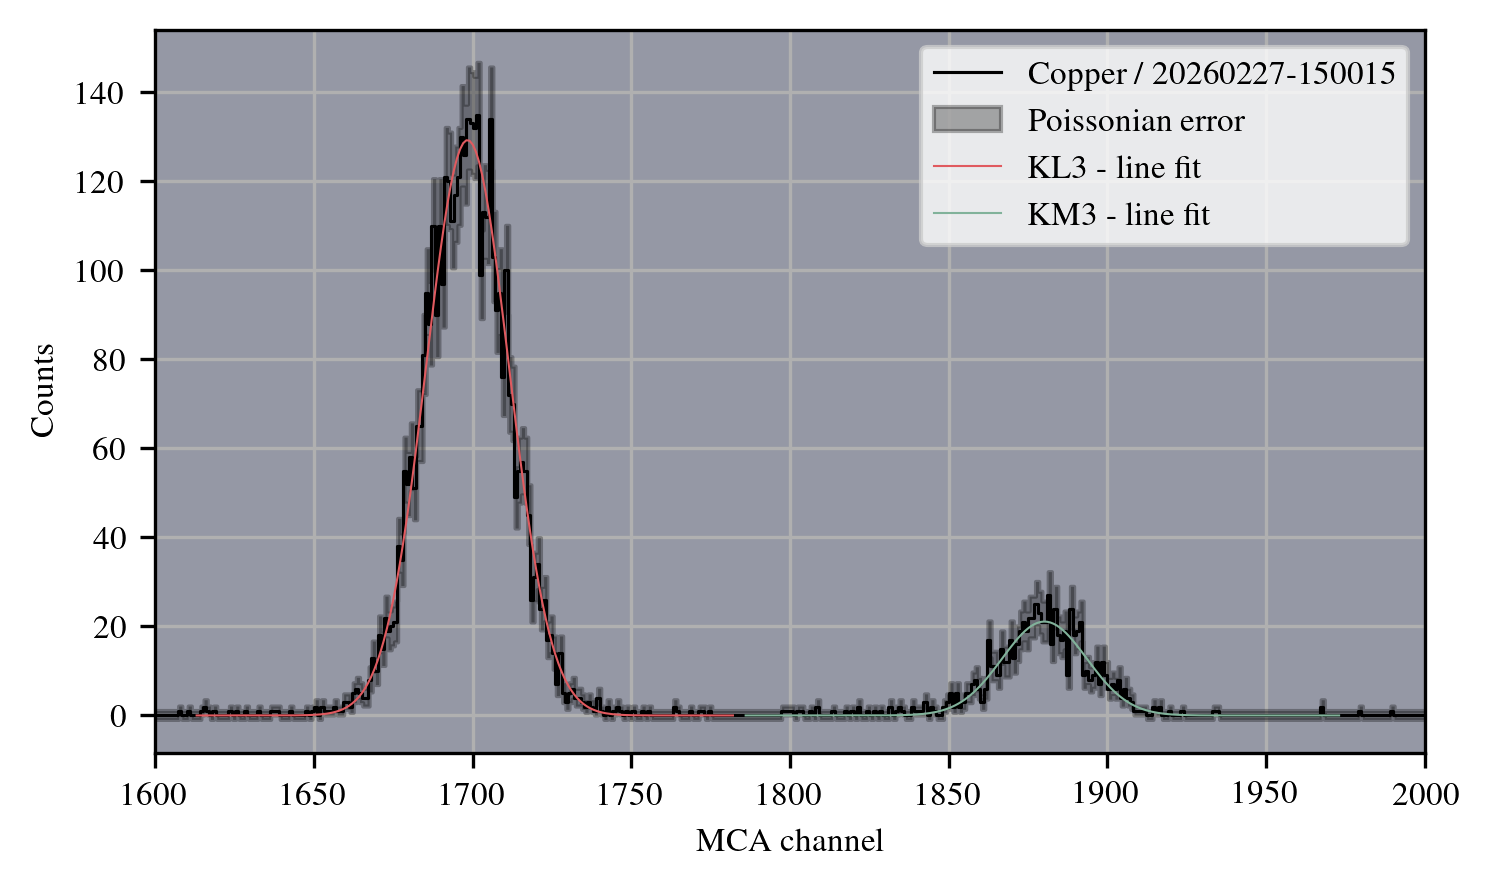

PARAMS: [ 312.15985791 2823.54102824   17.65571285]
UNCERT: [6.71508252 0.41810461 0.25372645]
PARAMS: [  50.86340874 3159.7891316    19.43720964]
UNCERT: [4.35658012 1.43501384 1.06917254]


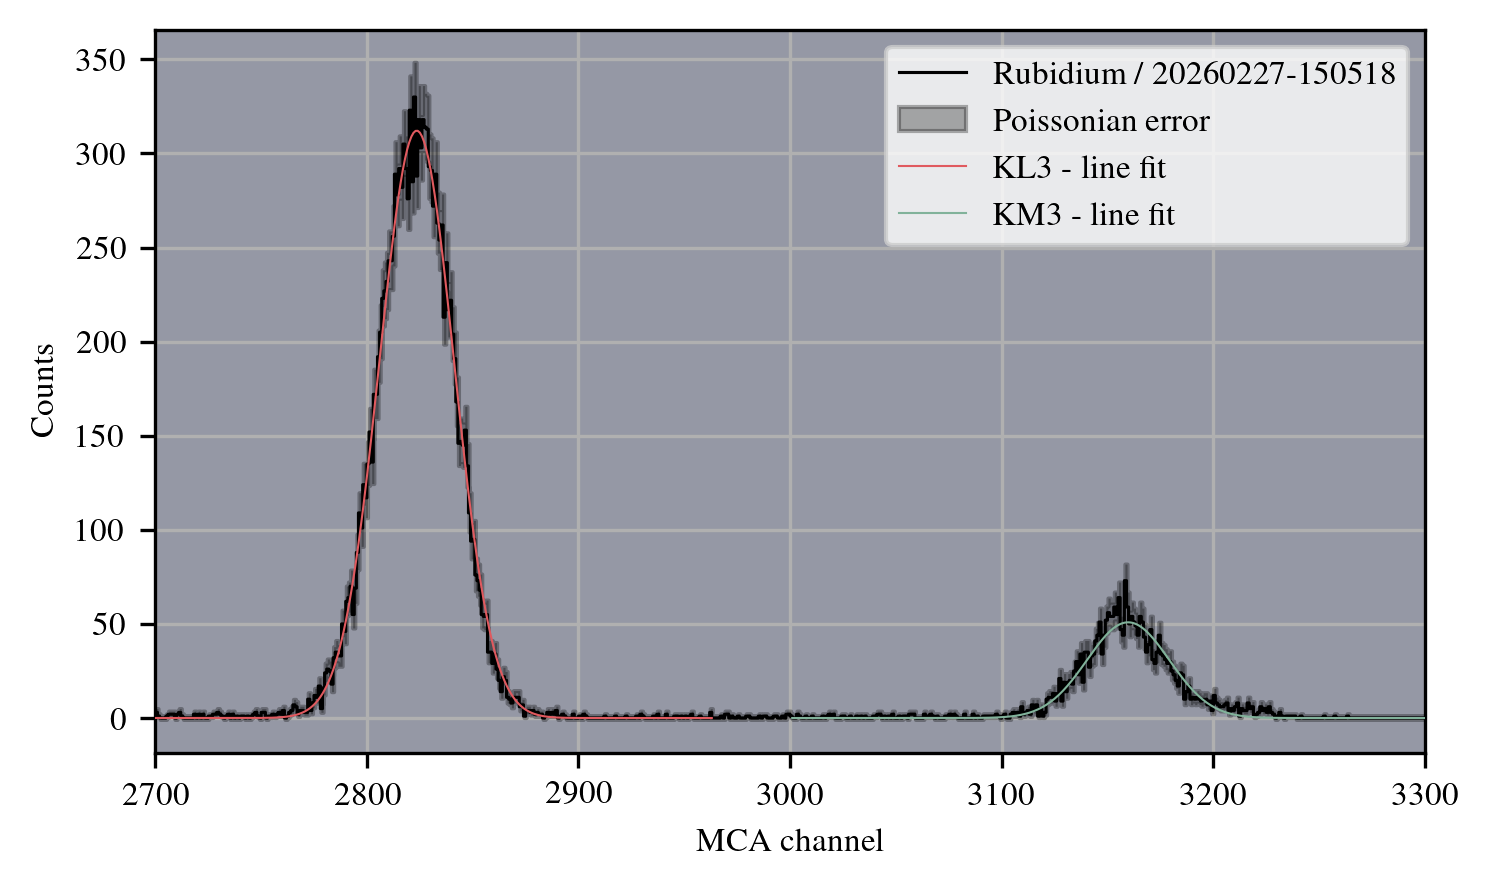

PARAMS: [ 550.83063133 2760.65804886   16.61356113]
UNCERT: [13.85429699  0.51735498  0.29402092]
PARAMS: [  93.08581882 3103.50856456   16.76819463]
UNCERT: [9.38269955 1.57702435 1.10069359]


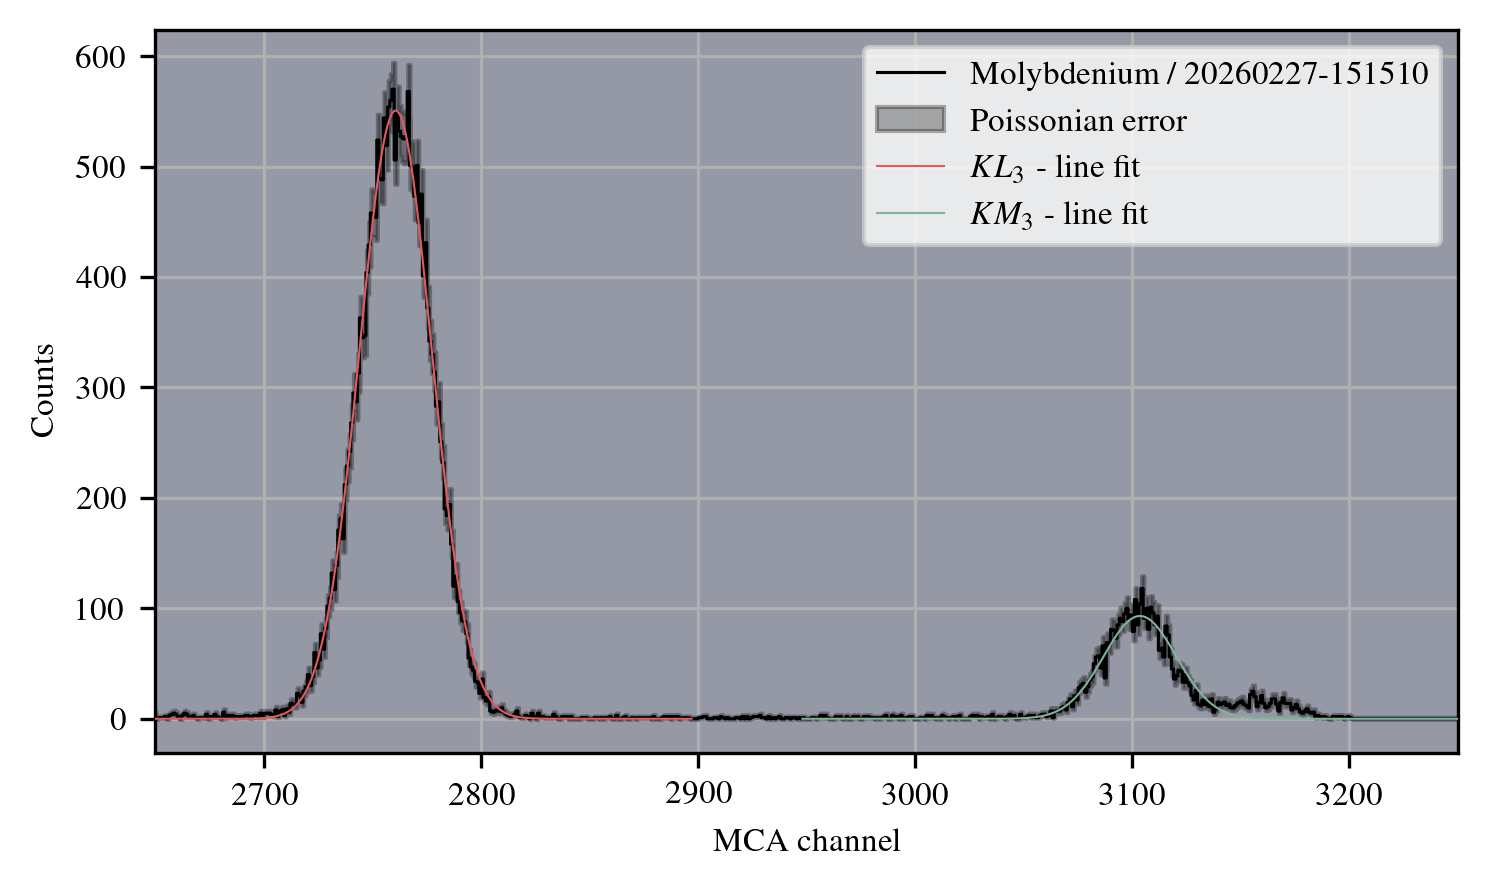

In [10]:
#------------ Copper, 5cm ------------#
file_to_analyze_Cu = './/2026_02_27//20260227-150015.vspc'

init_val = [[100,1700,20], [25,1850,12]]
xlim = [1600,2000]
info = ['Copper', 'KL3', 'KM3']

all_peaks_one_measurement(file = file_to_analyze_Cu, peaks = init_val, xlim=xlim, info=info)
#------------ Copper, 5cm ------------#

#------------ Rubidium, 5cm ------------#
file_to_analyze_Rb = './/2026_02_27//20260227-150518.vspc'

init_val = [[310,2700,20], [50,3100,10]]
xlim = [2700,3300]
info = ['Rubidium', 'KL3', 'KM3']

all_peaks_one_measurement(file = file_to_analyze_Rb, peaks = init_val, xlim=xlim, info=info)
#------------ Rubidium, 5cm ------------#

#------------ Molybdän, 5cm ------------#
file_to_analyze_Mo = './/2026_02_27//20260227-151510.vspc'

init_val = [[510,2700,20], [100,3100,10]]
xlim = [2650,3250]
info = ['Molybdenium', '$KL_3$', '$KM_3$']

all_peaks_one_measurement(file = file_to_analyze_Mo, peaks = init_val, xlim=xlim, info=info)
#------------ Molybdän, 5cm ------------#